In [41]:
import os
import jax
import jax.numpy as np
import numpy as onp
import jax.random as rjax
import flax
from flax import nn, optim, serialization
import matplotlib.pyplot as plt

In [2]:
from lib.params import mdn, mdstp, mpip

In [3]:
import matplotlib.pyplot as plt

In [43]:
path_data = './mcsamples'
path_models = './dat'

In [4]:
def get_vars(data):
    """ """
    e, mddsq, md1pisq = [data[:,i] for i in range(3)]
    tdd = (np.sqrt(mddsq) - 2*mdn)*10**3
    mask = tdd > 0
    pd = np.sqrt(np.clip(tdd, 0, None) * mdn * 10**3)
    md1pi = np.sqrt(md1pisq)
    return np.column_stack([e[mask], pd[mask], md1pi[mask]])

In [5]:
def draw_1d_projections(ax, data, bins=250, weights=None):
    labels = [r'$E (MeV)$', r'$p(D^0)$ (MeV)', r'$m(D^0pi^+)$ (GeV)']
    for idx, lbl in enumerate(labels):
        ax[idx].hist(data[:,idx], bins=bins, weights=weights);
        ax[idx].grid()
        ax[idx].set_xlabel(lbl)

In [6]:
def hist_2d(x, y, rng=None, bins=50, weights=None):
    hist, xbins, ybins = onp.histogram2d(x, y, bins=bins, range=rng, weights=weights)
    xbins = 0.5 * (xbins[:-1] + xbins[1:])
    ybins = 0.5 * (ybins[:-1] + ybins[1:])
    xv, yv = onp.meshgrid(xbins, ybins)
    return (xv, yv, hist.T)

In [7]:
def put_contours(ax, x, y, bins=20, levels=6, weights=None):
    ax.contourf(*hist_2d(x=x, y=y, rng=None, bins=[bins,bins], weights=weights), levels=levels)

In [8]:
def draw_2d_projections(ax, data, bins=20, levels=6, weights=None):
    for idx, (i, j) in enumerate([[0, 1], [0, 2], [1, 2]]):
        put_contours(ax[idx], data[:,i], data[:,j], bins, levels, weights)
        ax[idx].grid()

In [9]:
def normalize(data):
    means = [np.mean(data[:,i]) for i in range(3)]
    stds = [np.std(data[:,i]) for i in range(3)]
    newdata = np.column_stack([(data[:, i] - means[i]) / stds[i] for i in range(3)])
    return (newdata, means, stds)

In [10]:
@flax.struct.dataclass
class TrainState:
    optimizer: optim.Optimizer

In [11]:
class NN(nn.Module):
    def apply(self, x):
        x = nn.Dense(x, features=32)
        x = nn.relu(x)
        x = nn.Dense(x, features=32)
        x = nn.relu(x)
        x = nn.Dense(x, features=16)
        x = nn.relu(x)
        x = nn.Dense(x, features=1)
        return nn.sigmoid(x)

In [35]:
key = jax.random.PRNGKey(0)
_, initial_params = NN.init(key, np.zeros((10, 3)))
    
model = nn.Model(NN, initial_params)
    
adam = optim.Adam(learning_rate=0.003)
optimizer = adam.create(model)
    
state = TrainState(optimizer=optimizer)

re, im, ch = 41.0, 1.5, 250

with open('nn_model_3d_test_fit.dat', 'rb') as f:
    data = f.read()
        
restored_state = flax.serialization.from_bytes(state, data)
jax.tree_map(np.shape, flax.serialization.to_state_dict(restored_state))
        
model = nn.Model(NN, initial_params)
for layer in range(4):
    model.params[f'Dense_{layer}'] =\
        restored_state.optimizer.state_dict()['target']['params'][f'Dense_{layer}']
# model.replace(params=restored_state.optimizer.state_dict()['target']['params'])

# model.params['Dense_0']['bias'] = restored_state.optimizer.state_dict()['target']['params']['Dense_0']['bias']
# model.params['Dense_1']['bias'] = restored_state.optimizer.state_dict()['target']['params']['Dense_1']['bias']
# model.params['Dense_2']['bias'] = restored_state.optimizer.state_dict()['target']['params']['Dense_2']['bias']
# model.params['Dense_3']['bias'] = restored_state.optimizer.state_dict()['target']['params']['Dense_3']['bias']
model

Model(module=<class '__main__.NN'>, params={'Dense_0': {'kernel': array([[-0.40669298,  0.7407641 , -0.55459696,  0.86654246,  1.0474176 ,
        -0.40281716, -0.7488854 , -0.06316879,  0.1270135 ,  1.1394696 ,
         0.5355137 , -0.3285502 ,  0.8485936 , -1.2919761 ,  0.3311791 ,
        -0.24746868,  0.91903275,  1.1913675 ,  0.1516488 , -0.7803412 ,
        -1.0458776 ,  0.3230338 , -0.69038874,  1.1256745 , -0.758929  ,
         0.3703078 , -0.6319485 ,  0.5960354 ,  0.34397566,  0.17854665,
         0.9501185 , -1.2231178 ],
       [-0.156446  , -0.54600513, -0.0204754 , -0.5939019 ,  0.1198102 ,
        -0.09914881, -0.9340051 ,  0.0295719 , -0.0231733 , -0.778625  ,
         0.9253705 ,  0.39809144, -0.85138506,  0.5822102 , -0.550539  ,
        -0.3203855 ,  0.57707065,  0.39235684, -0.90600866, -0.69578886,
        -0.48243085,  0.1176056 ,  0.5072882 , -0.1335636 ,  0.0796812 ,
        -0.2566952 , -0.72678065,  1.2680199 ,  0.76102483,  0.29551774,
        -1.0481023 ,  0

In [17]:
restored_state.optimizer.state_dict()['target']['params']['Dense_0']['bias']

array([-0.46778986,  0.00631779, -0.44759795,  0.4032421 , -0.14800762,
       -0.2001644 ,  0.26138556,  0.34213755,  0.19778767,  0.33549732,
        0.03916249,  0.43231016,  0.36005804, -0.12160145,  0.02852632,
        0.41965154,  0.3056653 ,  0.31777576, -0.16221349,  0.03649598,
       -0.50882846,  0.3779648 , -0.17226678,  0.27849638, -0.5206198 ,
       -0.042453  ,  0.5651632 ,  0.3286103 , -1.08407   ,  0.41874903,
        0.02384321, -0.30081114], dtype=float32)

In [36]:
def uniform_sample(rg, limits, N):
    """ """
    lo = [x[0] for x in limits]
    hi = [x[1] for x in limits]
    return rg.uniform(lo, hi, (N, len(limits)))

In [37]:
def norm_sample(rg, samp, mult=10):
    norm_size = mult*samp.shape[0]
    limits = [[np.min(samp[:, i]), np.max(samp[:, i])] for i in range(samp.shape[1])]
    return uniform_sample(rg, limits, norm_size)

In [38]:
def smeared_samp_file(re, im, ch):
    return f'mc_ddpip_3d_gs{re:.2f}_{im:.2f}_ch{ch}_smeared.npy'

In [39]:
def get_sample(re, im, ch):
    return get_vars(np.load(os.path.join(path_data, smeared_samp_file(re, im, ch))))

In [47]:
def norm_file(re, im, ch):
    return f'norm_gs{re:.2f}_{im:.2f}_ch{ch}.npz'

In [48]:
def get_norm(re, im, ch):
    fname = os.path.join(path_models, norm_file(re, im, ch))
    if not os.path.isfile(fname):
        print('get_norm: {fname} not found')
    ndata = np.load(fname)
    return (ndata['mean'], ndata['std'])

In [44]:
smpl = get_sample(41, 1.5, 250)[:10000]
smpl.shape

(10000, 3)

In [45]:
rg = onp.random.Generator(onp.random.PCG64())
norm_smpl = norm_sample(rg, smpl)
norm_smpl.shape

(100000, 3)

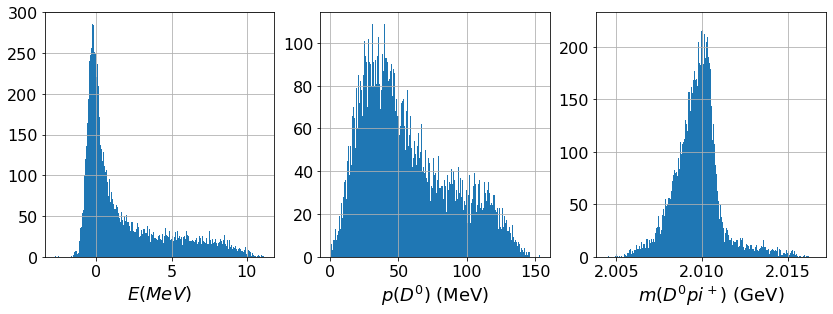

In [46]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4.5))
draw_1d_projections(ax, smpl, bins=250, weights=None)

In [49]:
means = onp.array([1.8590932, 56.122078, 2.0097547])
stds = onp.array([2.8228464, 32.606438, 0.00137304])

In [50]:
norm_norm_smpl = onp.empty(norm_smpl.shape)
for i in range(3):
    norm_norm_smpl[:, i] = (norm_smpl[:, i] - means[i]) / stds[i]

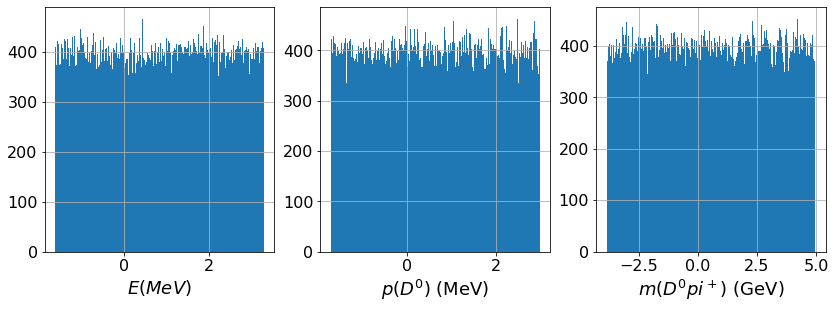

In [51]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4.5))
draw_1d_projections(ax, norm_norm_smpl, bins=250, weights=None)

In [54]:
w = model(norm_norm_smpl)
w.shape

(100000, 1)

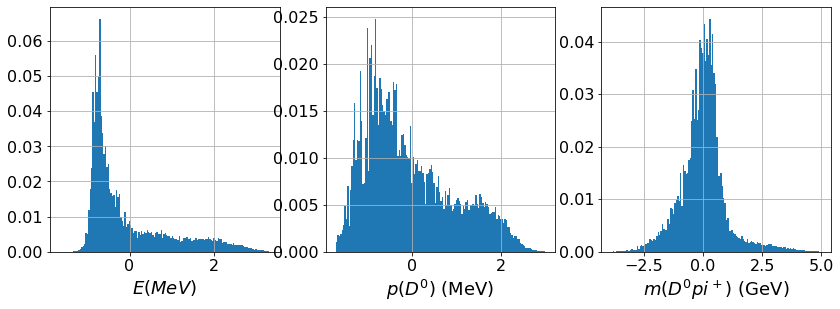

In [56]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4.5))
draw_1d_projections(ax, norm_norm_smpl, bins=150, weights=w.flatten())